In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
## from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [2]:
selected_num_columns = ['LotFrontage','LotArea','TotalBsmtSF','GrLivArea','SalePrice']
##Se selecciona porque garage cars porque tiene mejor correlacion con saleprice y ambas estaban muy correlacionadas
categorical_columns_filtered =  ['Street','LandContour',
                    'LandSlope','Utilities','Neighborhood','Condition1',
                    'Condition2','HouseStyle','BldgType','OverallQual',
                    'OverallCond','RoofStyle','Exterior1st',
                    'ExterCond', 'BsmtCond','BsmtFinType1','CentralAir',
                    'Heating','KitchenQual','TotRmsAbvGrd', 'GarageType',
                    'GarageCond','PavedDrive',
                    'SaleType','SaleCondition','Fireplaces',
                    'GarageCars',
                    ]

In [3]:
# Load the data
df = pd.read_csv('../data/train.csv')

df = df[selected_num_columns + categorical_columns_filtered]

In [4]:
# Basic data exploration
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum()[df.isnull().sum() > 0])

Dataset shape: (1460, 32)

Missing values:
 LotFrontage     259
BsmtCond         37
BsmtFinType1     37
GarageType       81
GarageCond       81
dtype: int64


In [5]:
# Handle missing values
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_columns:
    df[col].fillna(df[col].mean(), inplace=True)

categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


/tmp/ipykernel_34928/902036917.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
/tmp/ipykernel_34928/902036917.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [6]:
# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df, drop_first=True)

In [7]:
print([column for column in df_encoded.columns])
print(len(df_encoded.columns))

['LotFrontage', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'SalePrice', 'OverallQual', 'OverallCond', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'Street_Pave', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LandSlope_Mod', 'LandSlope_Sev', 'Utilities_NoSeWa', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_

In [8]:
# Split the data
X = df_encoded.drop(['SalePrice'], axis=1)
y = df_encoded['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Define XGBoost parameters grid
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3]
}

In [11]:
# Create XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

In [12]:
# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [13]:
# Fit the grid search
print("Performing grid search...")
grid_search.fit(X_train_scaled, y_train)

Performing grid search...
Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
# Print the best parameters and score
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format((-grid_search.best_score_)**0.5))


Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validation score: 29724.07


In [15]:
# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"RMSE: ${rmse:,.2f}")
print(f"R2 Score: {r2:.4f}")


Model Performance:
RMSE: $25,967.26
R2 Score: 0.9121


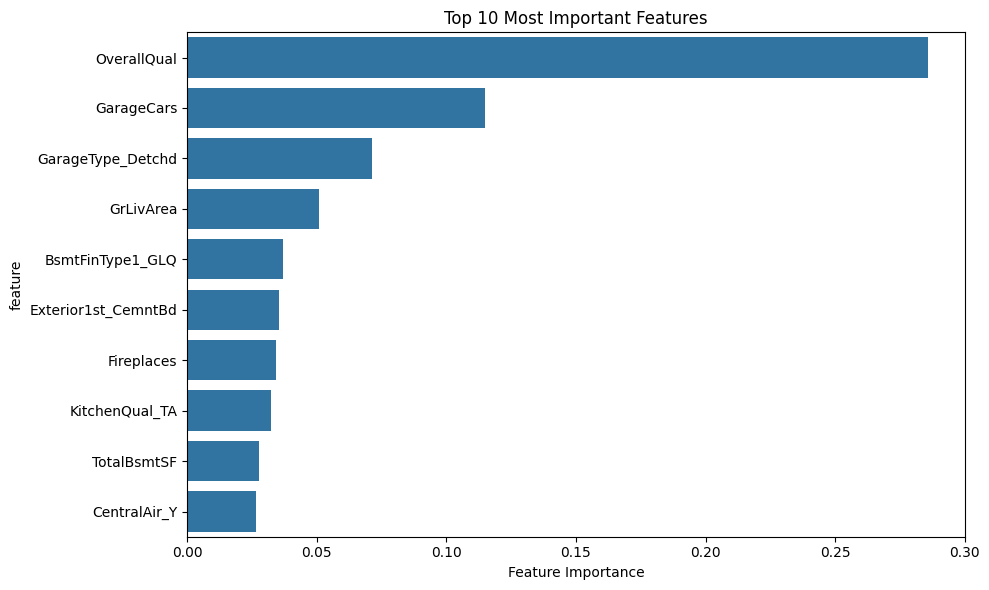

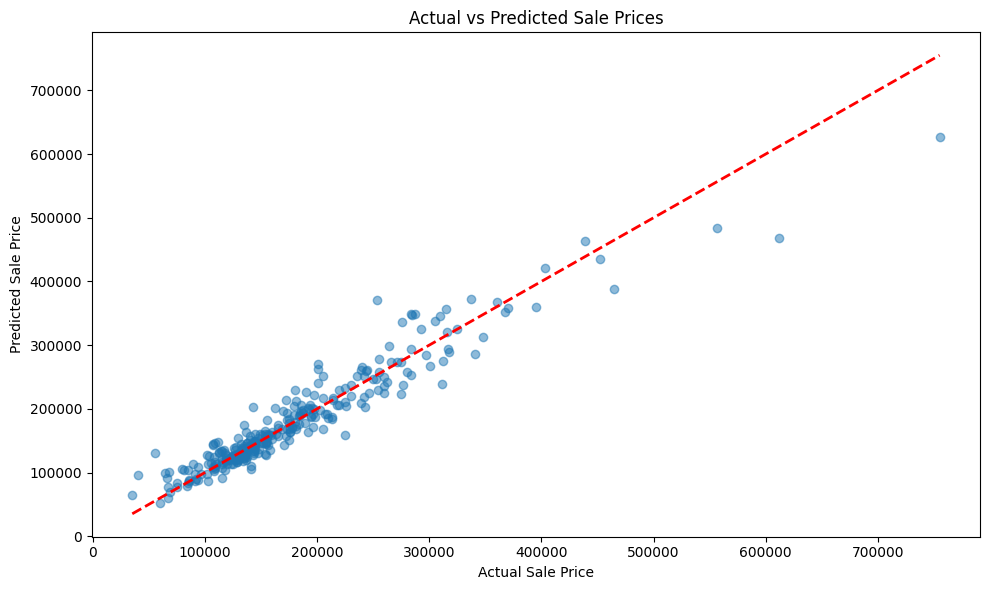

In [16]:
# Feature importance plot using the best model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Prices')
plt.tight_layout()
plt.show()